# Fall Recovery Training Notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"

In [3]:
import functools
import json
from datetime import datetime

import jax
import jax.numpy as jp
import matplotlib.pyplot as plt
import mediapy as media
import mujoco
import wandb
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from etils import epath
from flax.training import orbax_utils
from IPython.display import clear_output, display
from orbax import checkpoint as ocp
from tqdm import tqdm

from mujoco_playground import locomotion, wrapper
from mujoco_playground.config import locomotion_params

from vnl_mjx.tasks.rodent import flat_arena


# Enable persistent compilation cache.
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [4]:
env_name = "Go1Getup"
env_cfg = locomotion.get_default_config(env_name)
randomizer = locomotion.get_domain_randomizer(env_name)
ppo_params = locomotion_params.brax_ppo_config(env_name)

env_name = "rodent-flat"

In [5]:
env_cfg

Kd: 0.5
Kp: 35.0
action_repeat: 1
action_scale: 0.5
ctrl_dt: 0.02
drop_from_height_prob: 0.6
energy_termination_threshold: .inf
episode_length: 300
noise_config:
  level: 1.0
  scales:
    gravity: 0.05
    gyro: 0.2
    joint_pos: 0.03
    joint_vel: 1.5
reward_config:
  scales:
    action_rate: -0.001
    dof_acc: -2.5e-07
    dof_pos_limits: -0.1
    dof_vel: -0.1
    orientation: 1.0
    posture: 1.0
    stand_still: 1.0
    torques: -1.0e-05
    torso_height: 1.0
settle_time: 0.5
sim_dt: 0.004
soft_joint_pos_limit_factor: 0.95

In [6]:
from pprint import pprint

ppo_params.num_evals = 150
ppo_params.num_envs = 2048
ppo_params.num_timesteps = int(5e8)
pprint(ppo_params)

action_repeat: 1
batch_size: 256
discounting: 0.97
entropy_cost: 0.01
episode_length: 300
learning_rate: 0.0003
max_grad_norm: 1.0
network_factory:
  policy_hidden_layer_sizes: &id001 !!python/tuple
  - 512
  - 256
  - 128
  policy_obs_key: state
  value_hidden_layer_sizes: *id001
  value_obs_key: privileged_state
normalize_observations: true
num_envs: 2048
num_evals: 150
num_minibatches: 32
num_timesteps: 500000000
num_updates_per_batch: 4
reward_scaling: 1.0
unroll_length: 20



In [7]:
# Setup wandb logging.
USE_WANDB = True

if USE_WANDB:
    wandb.init(project="vnl-mjx-rl", config=env_cfg)
    wandb.config.update(
        {
            "env_name": env_name,
        }
    )

wandb: Currently logged in as: yuy004 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [8]:
SUFFIX = None
FINETUNE_PATH = None

# Generate unique experiment name.
now = datetime.now()
timestamp = now.strftime("%Y%m%d-%H%M%S")
exp_name = f"{env_name}-{timestamp}"
if SUFFIX is not None:
    exp_name += f"-{SUFFIX}"
print(f"Experiment name: {exp_name}")

# Possibly restore from the latest checkpoint.
if FINETUNE_PATH is not None:
    FINETUNE_PATH = epath.Path(FINETUNE_PATH)
    latest_ckpts = list(FINETUNE_PATH.glob("*"))
    latest_ckpts = [ckpt for ckpt in latest_ckpts if ckpt.is_dir()]
    latest_ckpts.sort(key=lambda x: int(x.name))
    latest_ckpt = latest_ckpts[-1]
    restore_checkpoint_path = latest_ckpt
    print(f"Restoring from: {restore_checkpoint_path}")
else:
    restore_checkpoint_path = None

Experiment name: rodent-flat-20250425-002332


In [9]:
ckpt_path = epath.Path("checkpoints").resolve() / exp_name
ckpt_path.mkdir(parents=True, exist_ok=True)
print(f"{ckpt_path}")

with open(ckpt_path / "config.json", "w") as fp:
    json.dump(env_cfg.to_dict(), fp, indent=4)

/root/vast/scott-yang/vnl-mjx/notebooks/checkpoints/rodent-flat-20250425-002332


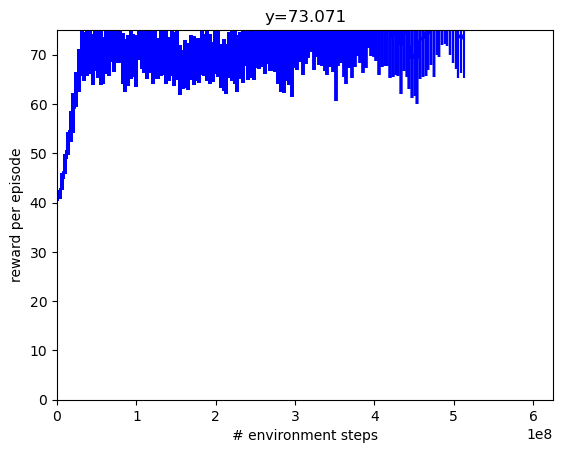

time to jit: 0:07:35.733780
time to train: 2:59:26.108482


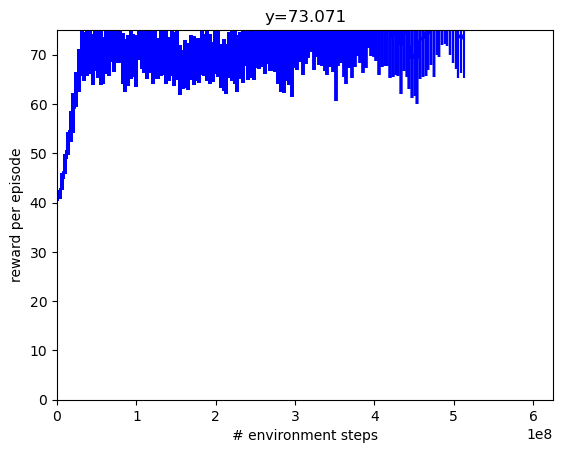

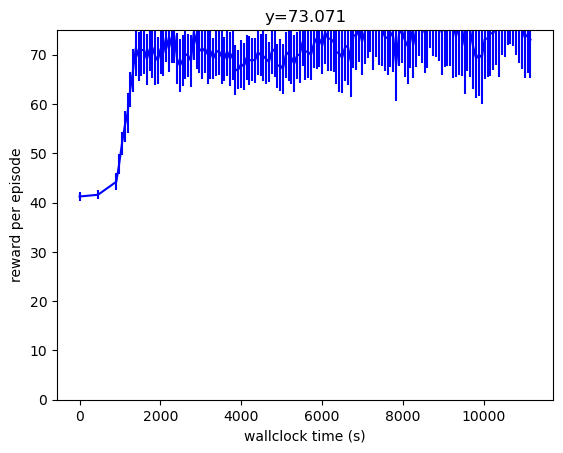

In [ ]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
    # Log to wandb.
    if USE_WANDB:
        wandb.log(metrics, step=num_steps)

    # Plot.
    clear_output(wait=True)
    times.append(datetime.now())
    x_data.append(num_steps)
    y_data.append(metrics["eval/episode_reward"])
    y_dataerr.append(metrics["eval/episode_reward_std"])

    plt.xlim([0, ppo_params.num_timesteps * 1.25])
    plt.ylim([0, 75])
    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.title(f"y={y_data[-1]:.3f}")
    plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

    display(plt.gcf())


def policy_params_fn(current_step, make_policy, params):
    del make_policy  # Unused.
    orbax_checkpointer = ocp.PyTreeCheckpointer()
    save_args = orbax_utils.save_args_from_target(params)
    path = ckpt_path / f"{current_step}"
    orbax_checkpointer.save(path, params, force=True, save_args=save_args)


training_params = dict(ppo_params)
del training_params["network_factory"]

train_fn = functools.partial(
    ppo.train,
    **training_params,
    network_factory=functools.partial(
        ppo_networks.make_ppo_networks, **ppo_params.network_factory
    ),
    restore_checkpoint_path=restore_checkpoint_path,
    progress_fn=progress,
    wrap_env_fn=wrapper.wrap_for_brax_training,
    policy_params_fn=policy_params_fn,
)

env = flat_arena.FlatWalk()
eval_env = flat_arena.FlatWalk()

make_inference_fn, params, _ = train_fn(environment=env, eval_env=eval_env)
if len(times) > 1:
    print(f"time to jit: {times[1] - times[0]}")
    print(f"time to train: {times[-1] - times[1]}")

# Make a final plot of reward and success vs WALLCLOCK time.
plt.figure()
plt.ylim([0, 75])
plt.xlabel("wallclock time (s)")
plt.ylabel("reward per episode")
plt.title(f"y={y_data[-1]:.3f}")
plt.errorbar(
    [(t - times[0]).total_seconds() for t in times[:-1]],
    y_data,
    yerr=y_dataerr,
    color="blue",
)
plt.show()

In [11]:
import pickle

# Save normalizer and policy params to the checkpoint dir.
normalizer_params, policy_params, value_params = params
with open(ckpt_path / "params.pkl", "wb") as f:
    data = {
        "normalizer_params": normalizer_params,
        "policy_params": policy_params,
        "value_params": value_params,
    }
    pickle.dump(data, f)

In [12]:
inference_fn = make_inference_fn(params, deterministic=True)
jit_inference_fn = jax.jit(inference_fn)

env_cfg.drop_from_height_prob = 1.0
eval_env = locomotion.load(env_name, config=env_cfg)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

ValueError: Env 'rodent-flat' not found. Available envs: dict_keys(['BarkourJoystick', 'BerkeleyHumanoidJoystickFlatTerrain', 'BerkeleyHumanoidJoystickRoughTerrain', 'G1JoystickFlatTerrain', 'G1JoystickRoughTerrain', 'Go1JoystickFlatTerrain', 'Go1JoystickRoughTerrain', 'Go1Getup', 'Go1Handstand', 'Go1Footstand', 'H1InplaceGaitTracking', 'H1JoystickGaitTracking', 'Op3Joystick', 'SpotFlatTerrainJoystick', 'SpotGetup', 'SpotJoystickGaitTracking', 'T1JoystickFlatTerrain', 'T1JoystickRoughTerrain'])

In [ ]:
rng = jax.random.PRNGKey(12345)
rollout = []
rewards = []
torso_height = []
actions = []
torques = []
power = []
qfrc_constraint = []
qvels = []
power1 = []
power2 = []
for _ in tqdm(range(10)):
    rng, reset_rng = jax.random.split(rng)
    state = jit_reset(reset_rng)
    for i in range(env_cfg.episode_length // 2):
        act_rng, rng = jax.random.split(rng)
        ctrl, _ = jit_inference_fn(state.obs, act_rng)
        actions.append(ctrl)
        state = jit_step(state, ctrl)
        rollout.append(state)
        rewards.append(
            {k[7:]: v for k, v in state.metrics.items() if k.startswith("reward/")}
        )
        torso_height.append(state.data.qpos[2])
        torques.append(state.data.actuator_force)
        qvel = state.data.qvel[6:]
        power.append(jp.sum(jp.abs(qvel * state.data.actuator_force)))
        qfrc_constraint.append(jp.linalg.norm(state.data.qfrc_constraint[6:]))
        qvels.append(jp.max(jp.abs(qvel)))
        frc = state.data.actuator_force
        qvel = state.data.qvel[6:]
        power1.append(jp.sum(frc * qvel))
        power2.append(jp.sum(jp.abs(frc * qvel)))

In [ ]:
power = jp.array(power1)
# Plot smoothed power.
power = jp.convolve(power, jp.ones(10) / 10, mode="valid")
plt.plot(power)
# Plot mean as a horizontal line.
plt.axhline(y=jp.mean(jp.array(power)), color="r", linestyle="-", label="Mean")
plt.legend()
plt.show()
# Print min and max.
print(f"Min power: {jp.min(power)}, Max power: {jp.max(power)}")

In [ ]:
plt.plot(qvels)
plt.axhline(2 * jp.pi, color="red", label="limit")
plt.legend()
plt.show()

In [ ]:
render_every = 2
fps = 1.0 / eval_env.dt / render_every
traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

frames = eval_env.render(
    traj, camera="side", scene_option=scene_option, height=480, width=640
)
media.show_video(frames, fps=fps, loop=False)
# media.write_video(f"{env_name}.mp4", frames, fps=fps, qp=18)